# Read data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Giả sử dữ liệu của bạn được load vào dataframe df
df = pd.read_csv("data/data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Chỉ quan tâm đến cột Adj Close
data = df['Adj Close']

# Phân chia dữ liệu
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train = data[:train_size]
val = data[train_size:train_size + val_size]
test = data[train_size + val_size:]


# Mean Method



In [2]:
# Tính trung bình trên tập train
mean_forecast = np.mean(train)

# Dự báo cho tập val và test
mean_val_forecast = [mean_forecast] * len(val)
mean_test_forecast = [mean_forecast] * len(test)

# Đánh giá hiệu suất
from sklearn.metrics import mean_squared_error

mse_val_mean = mean_squared_error(val, mean_val_forecast)
mse_test_mean = mean_squared_error(test, mean_test_forecast)

print(f"Mean Method - MSE trên tập val: {mse_val_mean:.4f}")
print(f"Mean Method - MSE trên tập test: {mse_test_mean:.4f}")


Mean Method - MSE trên tập val: 16.7405
Mean Method - MSE trên tập test: 25.1308


# Naïve Method

In [3]:
# Sử dụng giá trị gần nhất làm dự báo
naive_val_forecast = val.shift(1).fillna(method='bfill')  # Shift dữ liệu để dự báo
naive_test_forecast = test.shift(1).fillna(method='bfill')

# Đánh giá hiệu suất
mse_val_naive = mean_squared_error(val, naive_val_forecast)
mse_test_naive = mean_squared_error(test, naive_test_forecast)

print(f"Naïve Method - MSE trên tập val: {mse_val_naive:.4f}")
print(f"Naïve Method - MSE trên tập test: {mse_test_naive:.4f}")

Naïve Method - MSE trên tập val: 0.0034
Naïve Method - MSE trên tập test: 0.0007


/tmp/ipykernel_202830/3953236119.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_val_forecast = val.shift(1).fillna(method='bfill')  # Shift dữ liệu để dự báo
/tmp/ipykernel_202830/3953236119.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_test_forecast = test.shift(1).fillna(method='bfill')


# Vẽ kết quả dự báo

Mean Method không thay đổi theo thời gian, phù hợp để kiểm tra nếu chuỗi thời gian không có xu hướng hoặc biến động.
Naïve Method phù hợp hơn trong chuỗi có xu hướng mạnh hoặc dao động theo mùa.

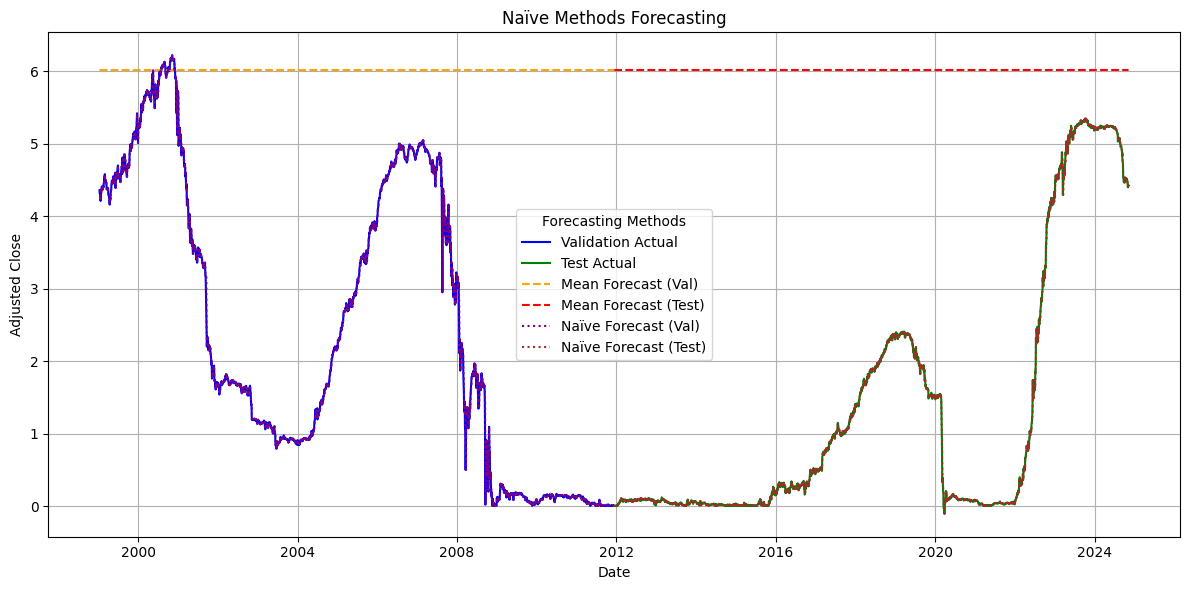

In [7]:
plt.figure(figsize=(12, 6))

# Vẽ dữ liệu thực tế
plt.plot(val.index, val, label='Validation Actual', color='blue')
plt.plot(test.index, test, label='Test Actual', color='green')

# Mean Method
plt.plot(val.index, mean_val_forecast, label='Mean Forecast (Val)', linestyle='--', color='orange')
plt.plot(test.index, mean_test_forecast, label='Mean Forecast (Test)', linestyle='--', color='red')

# Naïve Method
plt.plot(val.index, naive_val_forecast, label='Naïve Forecast (Val)', linestyle=':', color='purple')
plt.plot(test.index, naive_test_forecast, label='Naïve Forecast (Test)', linestyle=':', color='brown')

# Customize for clarity
plt.legend(loc='best', title='Forecasting Methods')  # Adjust legend position if needed
plt.title('Naïve Methods Forecasting')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust spacing for better formatting

# plt.legend()
# plt.title('Naïve Methods Forecasting')
# plt.xlabel('Date')
# plt.ylabel('Adj Close')
plt.show()


# AR

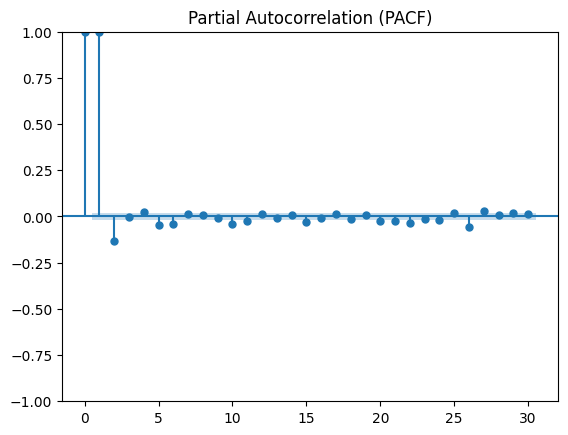

Độ trễ tối ưu: 27


In [8]:
# Thư viện cần thiết
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import numpy as np

# Tập dữ liệu train
train_values = train.values

# Xác định độ trễ tối ưu (lag order)
# Plot PACF để kiểm tra độ trễ
plot_pacf(train, lags=30, method='ywm')  # method='ywm' cho phép PACF tính chính xác hơn với chuỗi thời gian
plt.title("Partial Autocorrelation (PACF)")
plt.show()

# Dựa trên đồ thị hoặc sử dụng AIC/BIC
from statsmodels.tsa.stattools import adfuller

# Hàm thử nghiệm độ trễ tự động dựa trên tiêu chí AIC
def find_optimal_lag(data, max_lag=30):
    best_aic = np.inf
    best_lag = 0
    for lag in range(1, max_lag + 1):
        try:
            model = AutoReg(data, lags=lag, old_names=False).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_lag = lag
        except:
            continue
    return best_lag

optimal_lag = find_optimal_lag(train_values)
print(f"Độ trễ tối ưu: {optimal_lag}")

In [9]:
# Ước lượng mô hình AR
# Xây dựng mô hình với độ trễ tối ưu
ar_model = AutoReg(train_values, lags=optimal_lag, old_names=False).fit()

# In kết quả ước lượng
print(ar_model.summary())


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 9737
Model:                    AutoReg(27)   Log Likelihood                8149.450
Method:               Conditional MLE   S.D. of innovations              0.105
Date:                Mon, 18 Nov 2024   AIC                         -16240.901
Time:                        10:59:11   BIC                         -16032.654
Sample:                            27   HQIC                        -16170.307
                                 9737                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.003      2.686      0.007       0.002       0.012
y.L1           1.1402      0.010    112.399      0.000       1.120       1.160
y.L2          -0.1366      0.015     -8.894      0.0

AR Model - MSE trên tập val: 16.2229
AR Model - MSE trên tập test: 25.7386


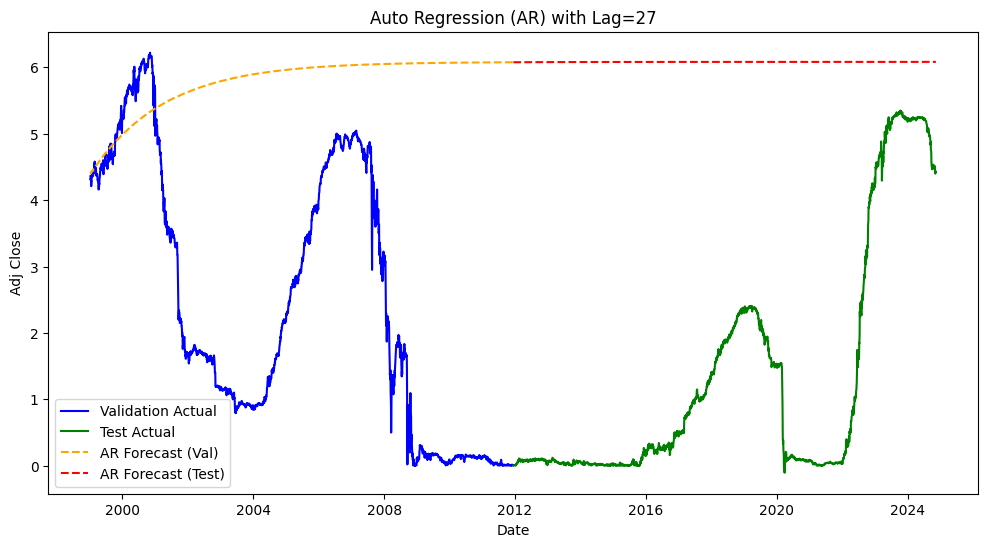

In [10]:
# Dự báo và đánh giá hiệu suất
# Dự báo trên tập val và test
val_forecast = ar_model.predict(start=len(train), end=len(train) + len(val) - 1)
test_forecast = ar_model.predict(start=len(train) + len(val), end=len(train) + len(val) + len(test) - 1)

# Đánh giá hiệu suất bằng MSE
from sklearn.metrics import mean_squared_error

mse_val = mean_squared_error(val, val_forecast)
mse_test = mean_squared_error(test, test_forecast)

print(f"AR Model - MSE trên tập val: {mse_val:.4f}")
print(f"AR Model - MSE trên tập test: {mse_test:.4f}")

# Vẽ kết quả dự báo
plt.figure(figsize=(12, 6))

# Dữ liệu thực tế
plt.plot(val.index, val, label='Validation Actual', color='blue')
plt.plot(test.index, test, label='Test Actual', color='green')

# AR Dự báo
plt.plot(val.index, val_forecast, label='AR Forecast (Val)', linestyle='--', color='orange')
plt.plot(test.index, test_forecast, label='AR Forecast (Test)', linestyle='--', color='red')

plt.legend()
plt.title(f'Auto Regression (AR) with Lag={optimal_lag}')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()


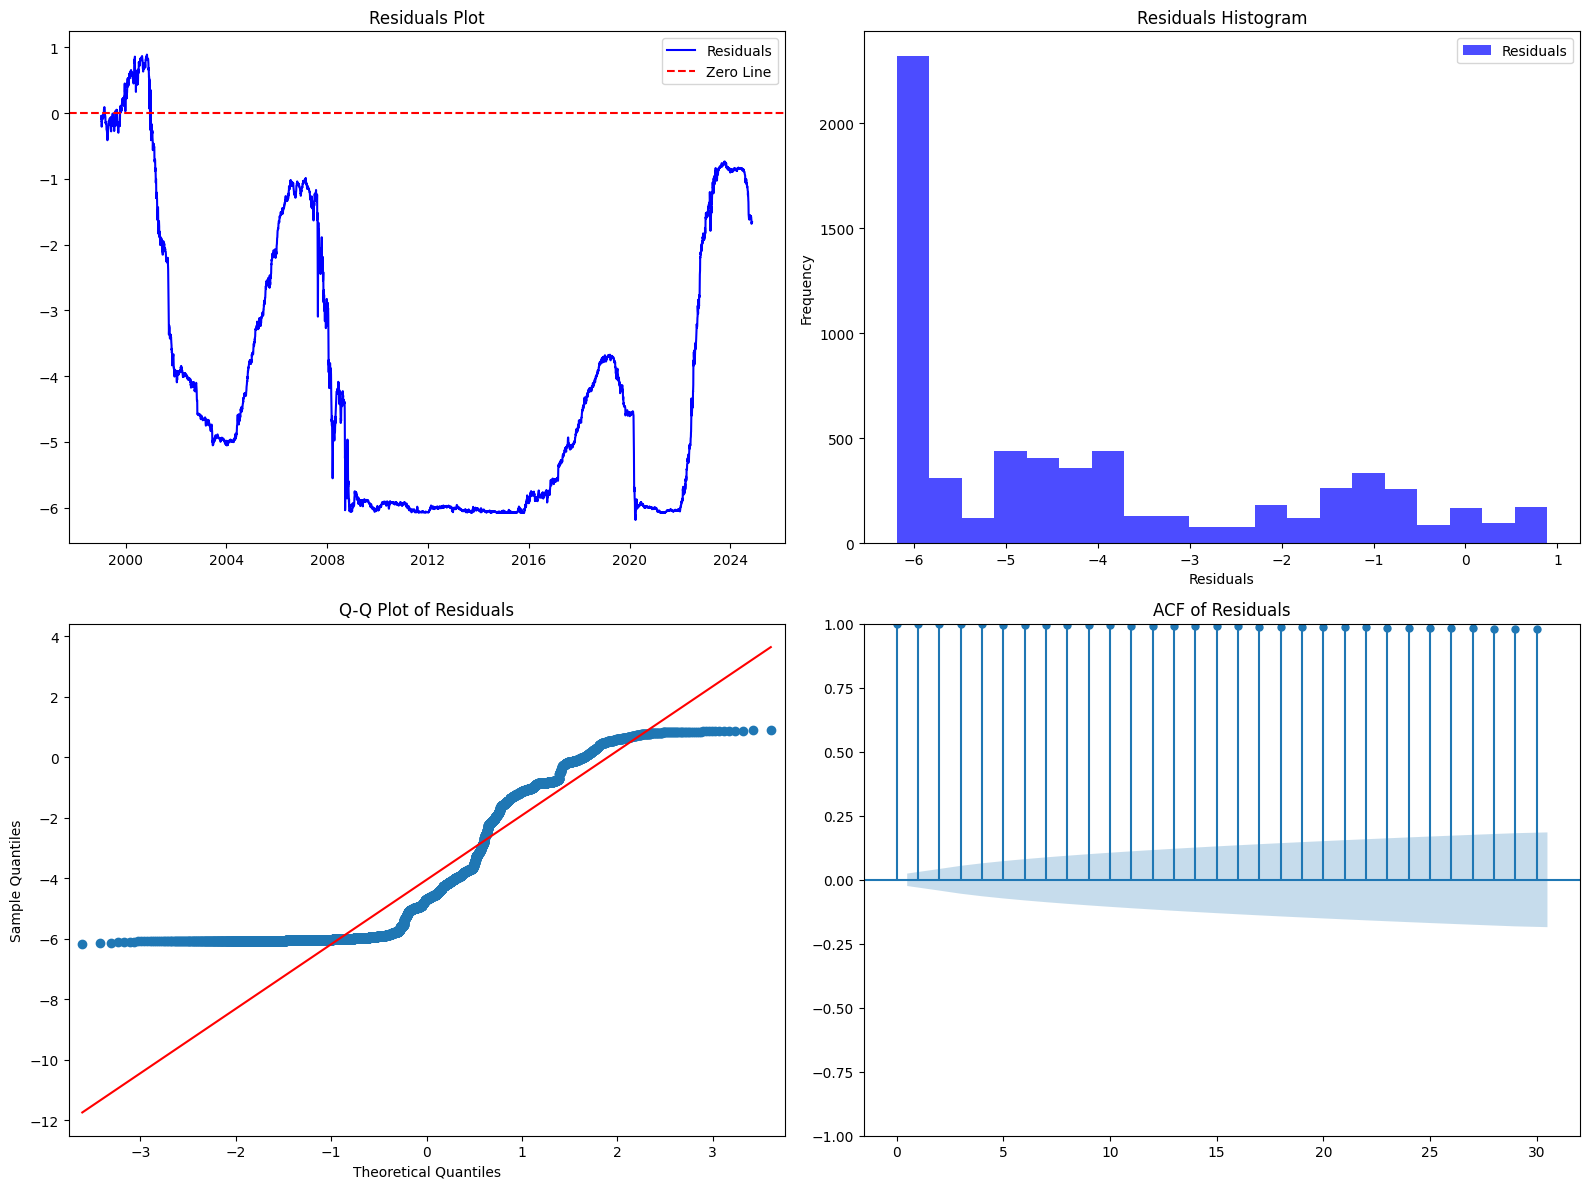

In [12]:
# Quan sát và phân tích phần dư
# Gộp val và test
# Chuyển đổi val_forecast và test_forecast thành pandas.Series
val_forecast_series = pd.Series(val_forecast, index=val.index)
test_forecast_series = pd.Series(test_forecast, index=test.index)

# Gộp dự báo
forecast_values = pd.concat([val_forecast_series, test_forecast_series])

# Gộp actual values
actual_values = pd.concat([val, test])

# Tính phần dư
residuals = actual_values - forecast_values

# Chúng ta sẽ tạo một figure với 4 biểu đồ:

#     Biểu đồ phần dư.
#     Histogram phần dư.
#     Q-Q plot phần dư.
#     ACF phần dư.
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(16, 12))

# Biểu đồ phần dư
plt.subplot(2, 2, 1)
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(y=0, linestyle='--', color='red', label='Zero Line')
plt.title('Residuals Plot')
plt.legend()

# Histogram phần dư
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=20, color='blue', alpha=0.7, label='Residuals')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()

# Q-Q plot phần dư
plt.subplot(2, 2, 3)
qqplot(residuals.dropna(), line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')

# ACF phần dư
plt.subplot(2, 2, 4)
plot_acf(residuals.dropna(), lags=30, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()


In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Kiểm tra tính dừng với ADF
adf_test = adfuller(residuals.dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] < 0.05:
    print("Phần dư có tính dừng (Reject Null Hypothesis)")
else:
    print("Phần dư không có tính dừng (Fail to Reject Null Hypothesis)")

# Kiểm tra tính ngẫu nhiên với Ljung-Box
ljung_box = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(ljung_box)

# Ý nghĩa của kết quả

#     Residuals Plot: Giúp kiểm tra xem phần dư có xu hướng hoặc mẫu bất thường nào không.
#     Histogram và Q-Q Plot: Kiểm tra phân phối chuẩn của phần dư.
#     ACF Plot: Kiểm tra xem phần dư có tự tương quan hay không.
#     ADF Test và Ljung-Box Test: Đưa ra kết luận thống kê về tính dừng và ngẫu nhiên của phần dư.

ADF Statistic: -1.818695889740444
p-value: 0.37121999913440873
Phần dư không có tính dừng (Fail to Reject Null Hypothesis)

Ljung-Box Test:
         lb_stat  lb_pvalue
10  64568.814922        0.0


# ARIMA

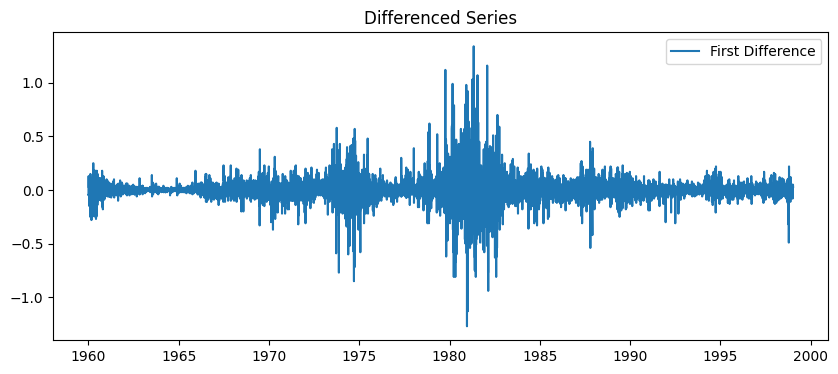

ADF Statistic: -15.910655283426376
p-value: 8.130881253090242e-29
Chuỗi dừng sau khi sai phân.


In [3]:
# Sai phân bậc 1
diff_train = train.diff().dropna()

# Kiểm tra trực quan chuỗi sau khi sai phân
plt.figure(figsize=(10, 4))
plt.plot(diff_train, label='First Difference')
plt.title('Differenced Series')
plt.legend()
plt.show()

# Kiểm tra tính dừng bằng Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(diff_train)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("Chuỗi dừng sau khi sai phân.")
else:
    print("Chuỗi chưa dừng, cần sai phân thêm.")


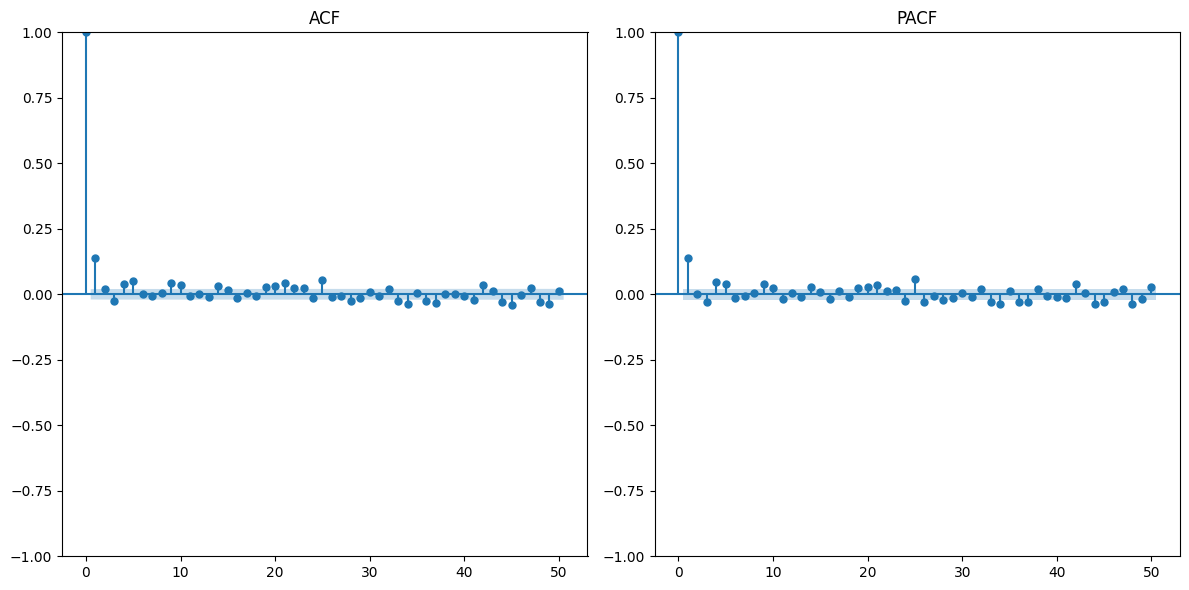

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(diff_train, lags=50, ax=plt.gca())
plt.title("ACF")

# PACF
plt.subplot(1, 2, 2)
plot_pacf(diff_train, lags=50, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()
# Hướng dẫn đọc đồ thị:

#     pp: Số lag trong PACF giảm về 0 hoặc không còn ý nghĩa (ngoài khoảng tin cậy).
#     qq: Số lag trong ACF giảm về 0 hoặc không còn ý nghĩa.

In [5]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Phạm vi các tham số
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)

# Tìm kiếm tham số tốt nhất
best_aic = float('inf')
best_order = None
best_model = None

for pdq in itertools.product(p, d, q):
    try:
        model = ARIMA(train, order=pdq)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = pdq
            best_model = results
    except:
        continue

print(f"Best ARIMA model: {best_order} with AIC: {best_aic}")


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it ha

Best ARIMA model: (2, 1, 4) with AIC: -16252.134023319506


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
# Mô hình ARIMA với tham số tối ưu
# Best ARIMA model: (2, 1, 4) with AIC: -16252.134023319506

optimal_order = best_order  # từ bước Grid Search
arima_model = ARIMA(train, order=optimal_order)
arima_fit = arima_model.fit()

# Kết quả
print(arima_fit.summary())


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to c

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 9737
Model:                 ARIMA(2, 1, 4)   Log Likelihood                8133.067
Date:                Mon, 18 Nov 2024   AIC                         -16252.134
Time:                        18:26:17   BIC                         -16201.849
Sample:                             0   HQIC                        -16235.090
                               - 9737                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7609      0.003    277.278      0.000       0.756       0.766
ar.L2         -0.9702      0.003   -311.659      0.000      -0.976      -0.964
ma.L1         -0.6212      0.005   -115.348      0.0

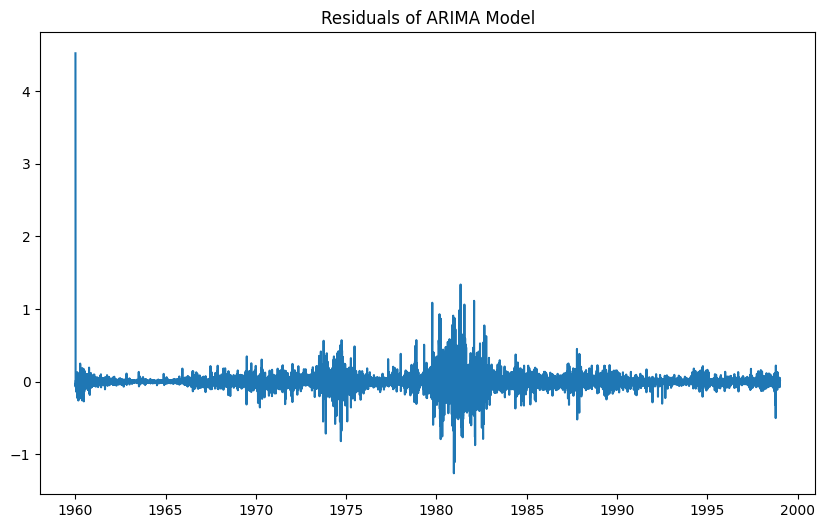

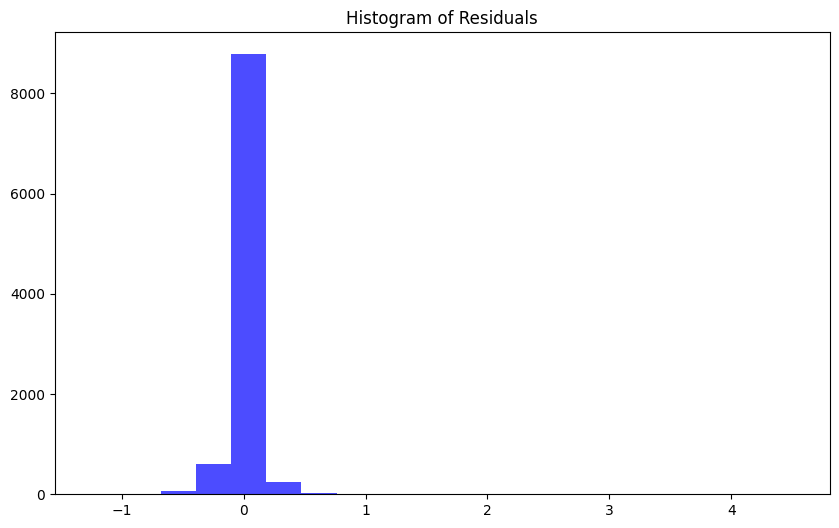

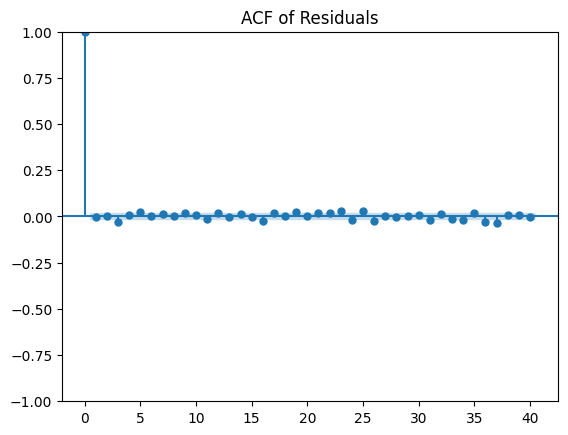

In [18]:
# Vẽ phần dư
residuals = arima_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

# Kiểm tra phân phối phần dư
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Residuals')
plt.show()

# Kiểm tra ACF của phần dư
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


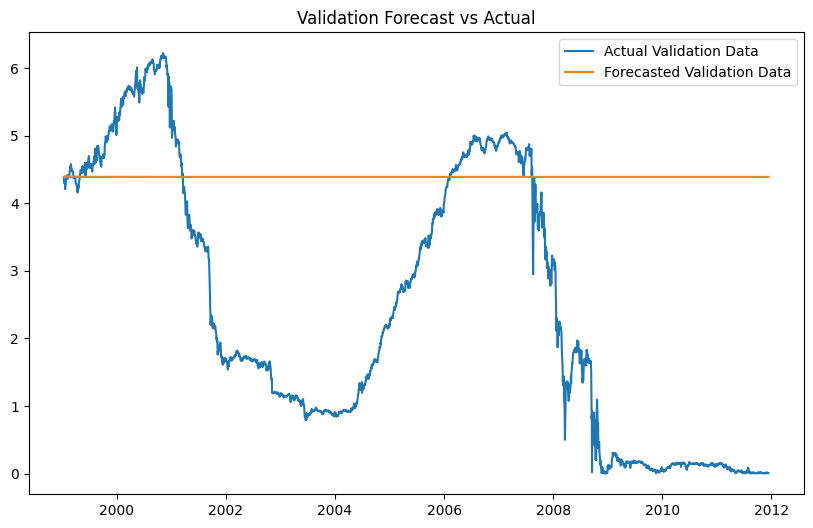

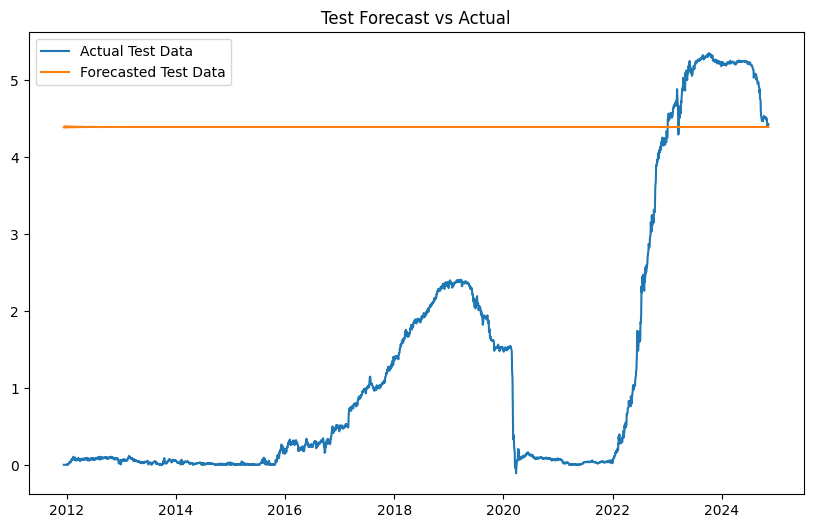

In [20]:
val_forecast = arima_fit.forecast(steps=len(val))
test_forecast = arima_fit.forecast(steps=len(test))

# Vẽ biểu đồ so sánh giữa dự báo và dữ liệu thực tế
plt.figure(figsize=(10, 6))
plt.plot(val.index, val, label='Actual Validation Data')
plt.plot(val.index, val_forecast, label='Forecasted Validation Data')
plt.title('Validation Forecast vs Actual')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, test_forecast, label='Forecasted Test Data')
plt.title('Test Forecast vs Actual')
plt.legend()
plt.show()


In [ ]:
# Dự báo trên tập val và test
val_forecast = arima_fit.forecast(steps=len(val), )
test_forecast = arima_fit.forecast(steps=len(test), exog=None)


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [8]:
# Dự báo trên tập val và test
val_forecast = arima_fit.forecast(steps=len(val))
test_forecast = arima_fit.forecast(steps=len(test))

# Tính phần dư
val_residuals = val.values - val_forecast
test_residuals = test.values - test_forecast


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# RMSE
rmse_val = np.sqrt(mean_squared_error(val, val_forecast))
rmse_test = np.sqrt(mean_squared_error(test, test_forecast))

# MAPE
mape_val = mean_absolute_percentage_error(val, val_forecast)
mape_test = mean_absolute_percentage_error(test, test_forecast)

print(f"RMSE (Val): {rmse_val}, RMSE (Test): {rmse_test}")
print(f"MAPE (Val): {mape_val:.2%}, MAPE (Test): {mape_test:.2%}")


RMSE (Val): 2.781487445393939, RMSE (Test): 3.5390688727399726
MAPE (Val): 3637.47%, MAPE (Test): 10271.42%


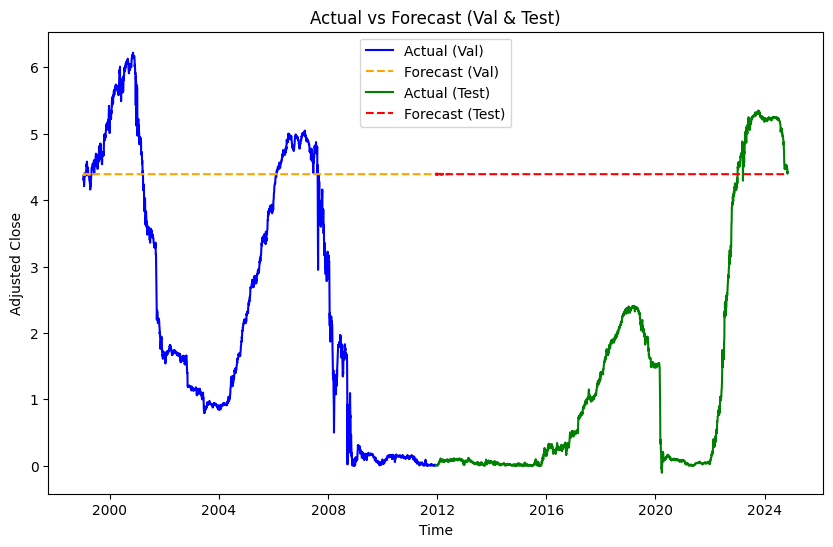

In [10]:
import matplotlib.pyplot as plt

# Vẽ kết quả dự báo trên tập val
plt.figure(figsize=(10, 6))

# Tập val
plt.plot(val.index, val, label='Actual (Val)', color='blue')
plt.plot(val.index, val_forecast, label='Forecast (Val)', color='orange', linestyle='--')

# Tập test
plt.plot(test.index, test, label='Actual (Test)', color='green')
plt.plot(test.index, test_forecast, label='Forecast (Test)', color='red', linestyle='--')

plt.title('Actual vs Forecast (Val & Test)')
plt.xlabel('Time')
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()


In [11]:
test_forecast

9737     4.388601
9738     4.383489
9739     4.386574
9740     4.395179
9741     4.398733
           ...   
12979    4.391214
12980    4.391214
12981    4.391214
12982    4.391214
12983    4.391214
Name: predicted_mean, Length: 3247, dtype: float64

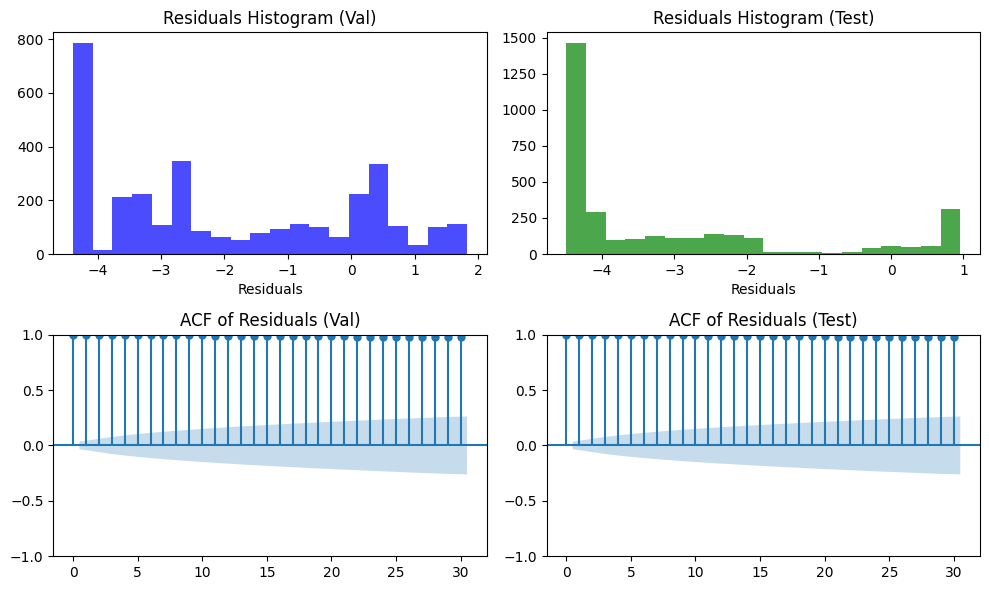

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))

# Histogram phần dư
plt.subplot(2, 2, 1)
plt.hist(val_residuals, bins=20, color='blue', alpha=0.7, label='Residuals (Val)')
plt.title('Residuals Histogram (Val)')
plt.xlabel('Residuals')

plt.subplot(2, 2, 2)
plt.hist(test_residuals, bins=20, color='green', alpha=0.7, label='Residuals (Test)')
plt.title('Residuals Histogram (Test)')
plt.xlabel('Residuals')

# ACF của phần dư
plt.subplot(2, 2, 3)
plot_acf(val_residuals, lags=30, ax=plt.gca())
plt.title('ACF of Residuals (Val)')

plt.subplot(2, 2, 4)
plot_acf(test_residuals, lags=30, ax=plt.gca())
plt.title('ACF of Residuals (Test)')

plt.tight_layout()
plt.show()


# SARIMA

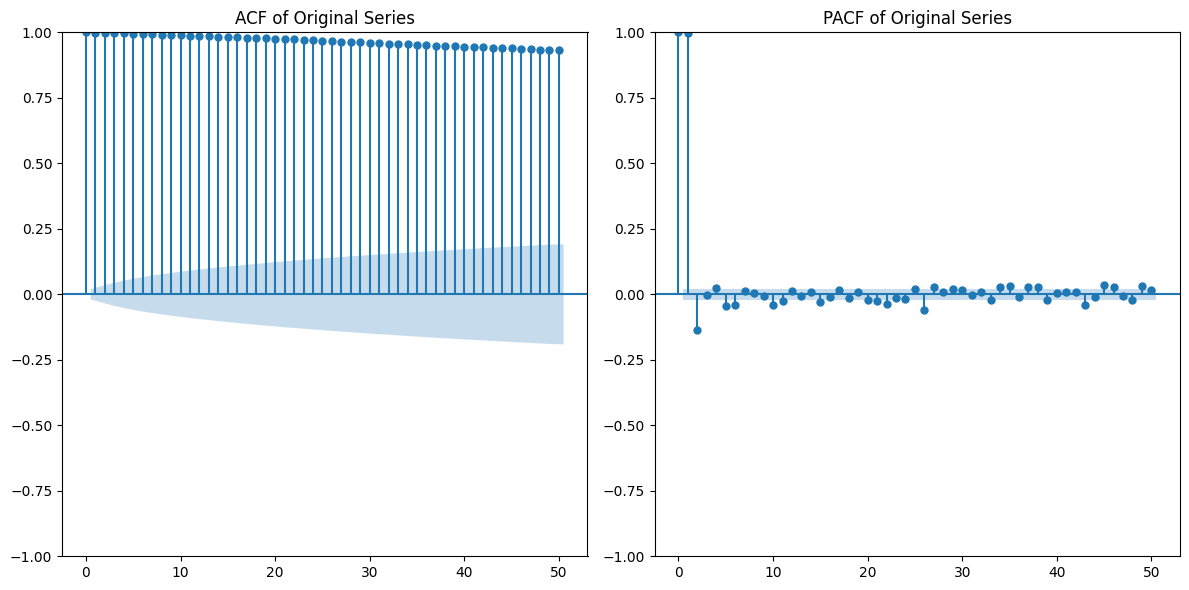

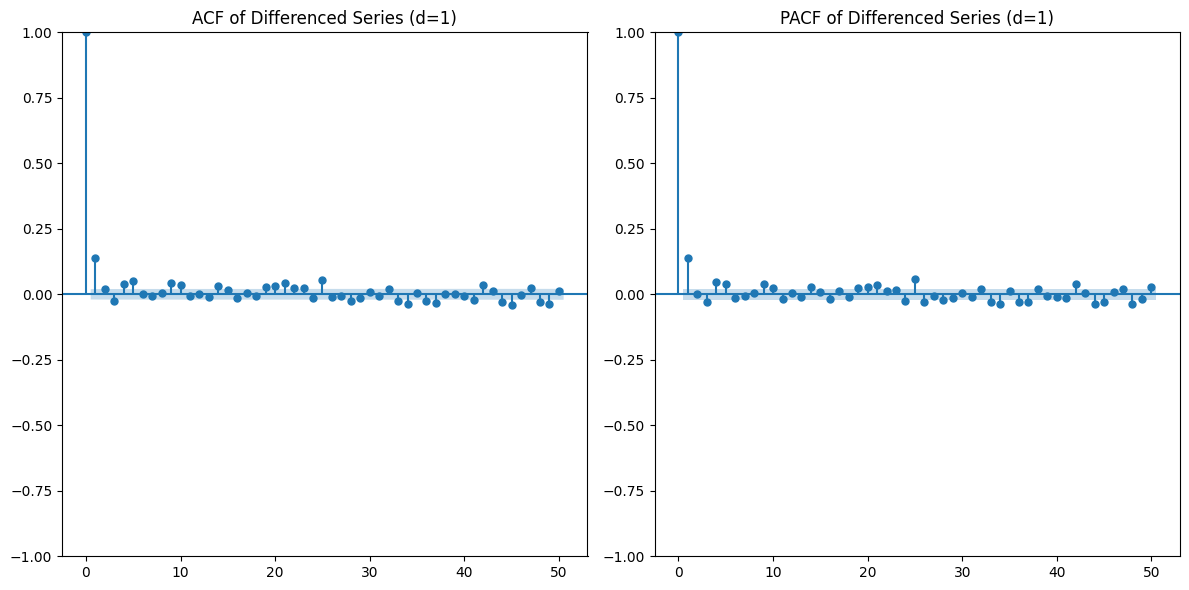

ADF Statistic: -15.910655283426376
p-value: 8.130881253090242e-29
Chuỗi đã dừng sau khi sai phân.


In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# 1. Vẽ ACF và PACF của chuỗi gốc
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(train, lags=50, ax=plt.gca())
plt.title('ACF of Original Series')

plt.subplot(1, 2, 2)
plot_pacf(train, lags=50, ax=plt.gca())
plt.title('PACF of Original Series')

plt.tight_layout()
plt.show()

# 2. Vẽ ACF và PACF của chuỗi sau khi sai phân bậc 1
diff_train = train.diff().dropna()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(diff_train, lags=50, ax=plt.gca())
plt.title('ACF of Differenced Series (d=1)')

plt.subplot(1, 2, 2)
plot_pacf(diff_train, lags=50, ax=plt.gca())
plt.title('PACF of Differenced Series (d=1)')

plt.tight_layout()
plt.show()

# 3. Kiểm tra tính dừng của chuỗi sau sai phân bậc 1
adf_test = adfuller(diff_train)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("Chuỗi đã dừng sau khi sai phân.")
else:
    print("Chuỗi chưa dừng, cần sai phân thêm.")


In [ ]:
# Giải thích các đồ thị:

#     ACF (Autocorrelation Function):
#         ACF đo lường mức độ tương quan giữa giá trị tại một thời điểm và các giá trị ở các thời điểm trước đó. Đối với SARIMA, ACF sẽ giúp bạn xác định các tham số qq và QQ.
#         Nếu ACF giảm dần (một cách chậm rãi) mà không đạt giá trị bằng 0 nhanh chóng, điều này có thể chỉ ra rằng mô hình của bạn có tính chất Moving Average (MA).

#     PACF (Partial Autocorrelation Function):
#         PACF đo lường mức độ tương quan giữa giá trị tại một thời điểm và các giá trị ở các thời điểm trước đó, sau khi loại bỏ ảnh hưởng của tất cả các lags giữa chúng.
#         PACF sẽ giúp bạn xác định tham số pp và PP. Nếu PACF giảm nhanh chóng xuống 0 sau vài lags, bạn có thể chọn pp nhỏ (ví dụ p=1p=1 hoặc p=2p=2).

#     Phần dư (Residuals):
#         Sau khi bạn huấn luyện mô hình, kiểm tra ACF và PACF của phần dư giúp đảm bảo rằng mô hình đã bắt được hết sự phụ thuộc trong dữ liệu và không còn autocorrelation đáng kể. Nếu có, có thể bạn cần phải điều chỉnh lại mô hình.

# Cách chọn tham số PP, DD, QQ:

#     PP (Seasonal AR): Nếu bạn thấy một peak rõ ràng trong PACF ở lag mùa vụ (ví dụ S=365S=365 cho chu kỳ năm), thì giá trị PP có thể được chọn là 1.
#     DD (Seasonal Differencing): Nếu chuỗi có xu hướng mùa vụ rõ ràng, bạn có thể thử sai phân mùa vụ D=1D=1.
#     QQ (Seasonal MA): Nếu bạn thấy một peak rõ ràng trong ACF ở lag mùa vụ, bạn có thể thử Q=1Q=1 hoặc Q=2Q=2.

# Lưu ý:

#     Chu kỳ mùa vụ SS: Bạn nên chọn chu kỳ mùa vụ SS dựa trên tính chất của dữ liệu. Ví dụ, nếu dữ liệu có tính mùa vụ theo năm, bạn có thể chọn S=365S=365 hoặc S=12S=12 nếu tính mùa vụ theo tháng.
#     Dự báo tốt hơn: Nếu bạn thấy rằng mô hình vẫn chưa bắt được cấu trúc mùa vụ tốt, bạn có thể thử các tham số mùa vụ khác nhau (ví dụ, thay đổi SS, hoặc thử nghiệm với PP, DD, QQ khác nhau).

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Xác định tham số cho mô hình SARIMA
# (p, d, q) cho phần không mùa vụ và (P, D, Q, S) cho phần mùa vụ
p = 2  # AR
d = 1  # Sai phân
q = 4  # MA
P = 1  # Seasonal AR
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA
S = 12  # Chu kỳ mùa vụ, giả sử mỗi năm có 12 tháng (có thể thay đổi tùy theo dữ liệu)

# Khởi tạo mô hình SARIMA
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))

# Ước lượng mô hình
sarima_fit = sarima_model.fit(disp=False)

# Tóm tắt kết quả mô hình
print(sarima_fit.summary())


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                            Adj Close   No. Observations:                 9737
Model:             SARIMAX(2, 1, 4)x(1, 1, [1], 12)   Log Likelihood                8076.239
Date:                              Mon, 18 Nov 2024   AIC                         -16134.478
Time:                                      18:34:01   BIC                         -16069.837
Sample:                                           0   HQIC                        -16112.567
                                             - 9737                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7012      0.011     64.977      0.000       0.680       0.722
ar.L2         -0.92

In [14]:
# Dự báo trên tập val và test
val_forecast_sarima = sarima_fit.forecast(steps=len(val))
test_forecast_sarima = sarima_fit.forecast(steps=len(test))

# Tính phần dư
val_residuals_sarima = val.values - val_forecast_sarima
test_residuals_sarima = test.values - test_forecast_sarima


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# RMSE
rmse_val_sarima = np.sqrt(mean_squared_error(val, val_forecast_sarima))
rmse_test_sarima = np.sqrt(mean_squared_error(test, test_forecast_sarima))

# MAPE
mape_val_sarima = mean_absolute_percentage_error(val, val_forecast_sarima)
mape_test_sarima = mean_absolute_percentage_error(test, test_forecast_sarima)

print(f"RMSE (Val) SARIMA: {rmse_val_sarima}, RMSE (Test) SARIMA: {rmse_test_sarima}")
print(f"MAPE (Val) SARIMA: {mape_val_sarima:.2%}, MAPE (Test) SARIMA: {mape_test_sarima:.2%}")


RMSE (Val) SARIMA: 2.768449336825965, RMSE (Test) SARIMA: 3.533701955687942
MAPE (Val) SARIMA: 3613.97%, MAPE (Test) SARIMA: 10263.02%


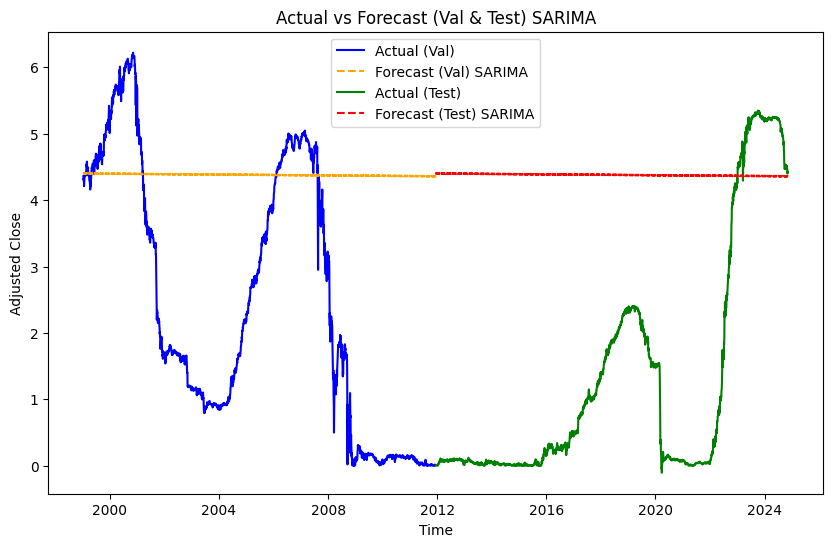

In [16]:
import matplotlib.pyplot as plt

# Vẽ kết quả dự báo trên tập val và test
plt.figure(figsize=(10, 6))

# Tập val
plt.plot(val.index, val, label='Actual (Val)', color='blue')
plt.plot(val.index, val_forecast_sarima, label='Forecast (Val) SARIMA', color='orange', linestyle='--')

# Tập test
plt.plot(test.index, test, label='Actual (Test)', color='green')
plt.plot(test.index, test_forecast_sarima, label='Forecast (Test) SARIMA', color='red', linestyle='--')

plt.title('Actual vs Forecast (Val & Test) SARIMA')
plt.xlabel('Time')
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()


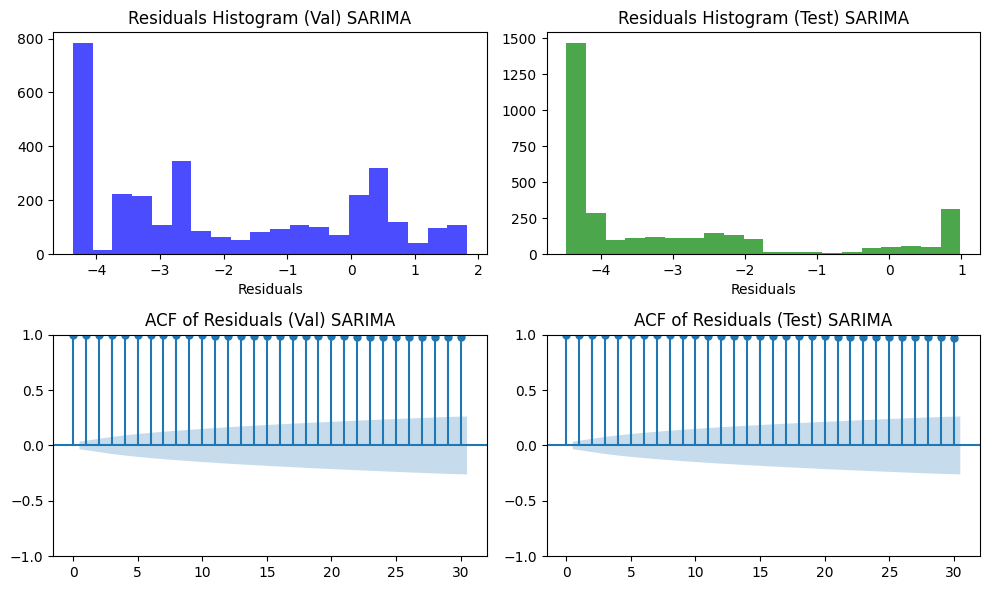

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))

# Histogram phần dư
plt.subplot(2, 2, 1)
plt.hist(val_residuals_sarima, bins=20, color='blue', alpha=0.7, label='Residuals (Val) SARIMA')
plt.title('Residuals Histogram (Val) SARIMA')
plt.xlabel('Residuals')

plt.subplot(2, 2, 2)
plt.hist(test_residuals_sarima, bins=20, color='green', alpha=0.7, label='Residuals (Test) SARIMA')
plt.title('Residuals Histogram (Test) SARIMA')
plt.xlabel('Residuals')

# ACF của phần dư
plt.subplot(2, 2, 3)
plot_acf(val_residuals_sarima, lags=30, ax=plt.gca())
plt.title('ACF of Residuals (Val) SARIMA')

plt.subplot(2, 2, 4)
plot_acf(test_residuals_sarima, lags=30, ax=plt.gca())
plt.title('ACF of Residuals (Test) SARIMA')

plt.tight_layout()
plt.show()


# 

In [ ]:
from arch import arch_model
# Đây là một ví dụ cơ bản với ARFIMA (d = 0.5)
model_arfima = arch_model(train, vol='Garch', p=2, q=2, dist='normal', lags=1000)
arfima_fit = model_arfima.fit()
print(arfima_fit.summary())
